# Machine Learning 382 Project: BrightPath Academy #


## Problem Statement ##

**BrightPath Academy** struggles to identify at-risk students early and tailor interventions due to delayed insights and data overload. This project aims to develop a machine learning model the Student_performance_data to classify students’ GradeClass (A–F) using demographic, academic, and extracurricular data, enabling timely interventions and personalised support strategies.

## Hypothesis Generation ##

- If a student has more than 15 absences, then they are more likely to have a GradeClass of D or F.
- Weekly study time positively impacts GPA.
- Frequent absences negatively affect academic performance.
- Students with higher parental involvement (ParentalSupport) tend to achieve better grades.
- Participation in extracurricular activities positively impacts GPA.


## Getting the system ready and loading the data ##


In [1]:
import xgboost
print(xgboost.__version__)

3.0.0


Importing Libraries

In [2]:
import numpy as np 
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

Load the Data

In [3]:
df = pd.read_csv('Student_performance_data .csv')

## Understanding the Data ##

In [4]:
print(df.info())
print(df.shape)

print(df.describe())

print(df.isnull().sum())

print(df['GradeClass'].value_counts())
print(df['GradeClass'].value_counts(normalize=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2392 entries, 0 to 2391
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   StudentID          2392 non-null   int64  
 1   Age                2392 non-null   int64  
 2   Gender             2392 non-null   int64  
 3   Ethnicity          2392 non-null   int64  
 4   ParentalEducation  2392 non-null   int64  
 5   StudyTimeWeekly    2392 non-null   float64
 6   Absences           2392 non-null   int64  
 7   Tutoring           2392 non-null   int64  
 8   ParentalSupport    2392 non-null   int64  
 9   Extracurricular    2392 non-null   int64  
 10  Sports             2392 non-null   int64  
 11  Music              2392 non-null   int64  
 12  Volunteering       2392 non-null   int64  
 13  GPA                2392 non-null   float64
 14  GradeClass         2392 non-null   float64
dtypes: float64(3), int64(12)
memory usage: 280.4 KB
None
(2392, 15)
        

Inspect first 5 Rows

In [5]:
display(df.head())

,StudentID,Age,Gender,Ethnicity,ParentalEducation,StudyTimeWeekly,Absences,Tutoring,ParentalSupport,Extracurricular,Sports,Music,Volunteering,GPA,GradeClass
0,1001,17,1,0,2,19.833723,7,1,2,0,0,1,0,2.929196,2.0
1,1002,18,0,0,1,15.408756,0,0,1,0,0,0,0,3.042915,1.0
2,1003,15,0,2,3,4.210570,26,0,2,0,0,0,0,0.112602,4.0
3,1004,17,1,0,3,10.028829,14,0,3,1,0,0,0,2.054218,3.0
4,1005,17,1,0,2,4.672495,17,1,3,0,0,0,0,1.288061,4.0


Descriptive Statistics

In [6]:
display(df.describe().T)

,count,mean,std,min,25%,50%,75%,max
StudentID,2392.0,2196.500000,690.655244,1001.000000,1598.750000,2196.500000,2794.250000,3392.000000
Age,2392.0,16.468645,1.123798,15.000000,15.000000,16.000000,17.000000,18.000000
Gender,2392.0,0.510870,0.499986,0.000000,0.000000,1.000000,1.000000,1.000000
Ethnicity,2392.0,0.877508,1.028476,0.000000,0.000000,0.000000,2.000000,3.000000
ParentalEducation,2392.0,1.746237,1.000411,0.000000,1.000000,2.000000,2.000000,4.000000
StudyTimeWeekly,2392.0,9.771992,5.652774,0.001057,5.043079,9.705363,14.408410,19.978094
Absences,2392.0,14.541388,8.467417,0.000000,7.000000,15.000000,22.000000,29.000000
Tutoring,2392.0,0.301421,0.458971,0.000000,0.000000,0.000000,1.000000,1.000000
ParentalSupport,2392.0,2.122074,1.122813,0.000000,1.000000,2.000000,3.000000,4.000000
Extracurricular,2392.0,0.383361,0.486307,0.000000,0.000000,0.000000,1.000000,1.000000


Feature Selection

In [7]:
all_vars = df.columns
output_var = 'GradeClass'
input_vars = all_vars.drop(output_var).to_list()

df_inputs = df[input_vars]
df_outputs = df[output_var]
print(f'There are now {len(df_inputs.columns)} input variables.')

display(df_inputs.head())

There are now 14 input variables.


,StudentID,Age,Gender,Ethnicity,ParentalEducation,StudyTimeWeekly,Absences,Tutoring,ParentalSupport,Extracurricular,Sports,Music,Volunteering,GPA
0,1001,17,1,0,2,19.833723,7,1,2,0,0,1,0,2.929196
1,1002,18,0,0,1,15.408756,0,0,1,0,0,0,0,3.042915
2,1003,15,0,2,3,4.210570,26,0,2,0,0,0,0,0.112602
3,1004,17,1,0,3,10.028829,14,0,3,1,0,0,0,2.054218
4,1005,17,1,0,2,4.672495,17,1,3,0,0,0,0,1.288061


Check for Unique values

In [8]:
df[input_vars].nunique().sort_values(ascending=False).head(10)

StudentID            2392
StudyTimeWeekly      2392
GPA                  2371
Absences               30
ParentalEducation       5
ParentalSupport         5
Age                     4
Ethnicity               4
Gender                  2
Tutoring                2
dtype: int64

Categorizing the Data

In [9]:
# Categorical columns
int_col = [col for col in df.columns if df[col].dtype == 'int64']
print('Integer columns :',int_col)
# Numerical columns
float_col = [col for col in df.columns if df[col].dtype == 'float64']
print('Float columns :',float_col)

Integer columns : ['StudentID', 'Age', 'Gender', 'Ethnicity', 'ParentalEducation', 'Absences', 'Tutoring', 'ParentalSupport', 'Extracurricular', 'Sports', 'Music', 'Volunteering']
Float columns : ['StudyTimeWeekly', 'GPA', 'GradeClass']


Check for Duplicates

In [10]:
duplicates = df[df.duplicated()]

print(duplicates)

Empty DataFrame
Columns: [StudentID, Age, Gender, Ethnicity, ParentalEducation, StudyTimeWeekly, Absences, Tutoring, ParentalSupport, Extracurricular, Sports, Music, Volunteering, GPA, GradeClass]
Index: []


Check for missing Values

In [11]:
df.isna().sum()

StudentID            0
Age                  0
Gender               0
Ethnicity            0
ParentalEducation    0
StudyTimeWeekly      0
Absences             0
Tutoring             0
ParentalSupport      0
Extracurricular      0
Sports               0
Music                0
Volunteering         0
GPA                  0
GradeClass           0
dtype: int64

## Correlation Graph to Clean Unneccessary Data ##

C:\Users\calvi\AppData\Local\Temp\ipykernel_12952\865229569.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlation_with_gradeclass.values, y=correlation_with_gradeclass.index, palette='coolwarm')


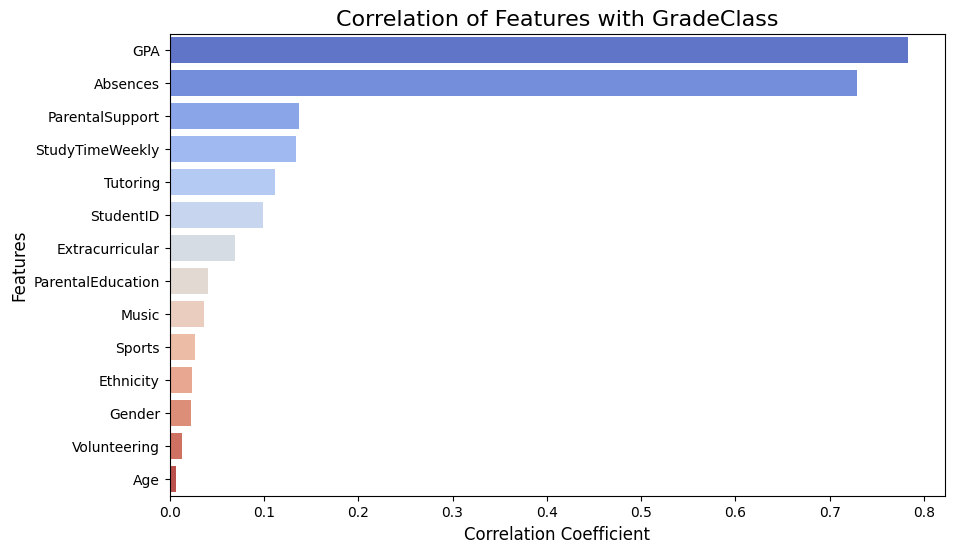

In [12]:
# Calculate correlation of all features with 'GradeClass'
correlation_with_gradeclass = df.corr()['GradeClass'].drop('GradeClass')

# Sort correlations by absolute value for better visualization
correlation_with_gradeclass = correlation_with_gradeclass.abs().sort_values(ascending=False)

# Plot the correlations
plt.figure(figsize=(10, 6))
sns.barplot(x=correlation_with_gradeclass.values, y=correlation_with_gradeclass.index, palette='coolwarm')
plt.title('Correlation of Features with GradeClass', fontsize=16)
plt.xlabel('Correlation Coefficient', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.show()

In [13]:
def CorrPlot(df, dropDuplicates = True, figsize = (8, 6)):
    # df = df.corr()
    df = np.abs(df.corr())
    # Exclude duplicate correlations by masking upper right values
    if dropDuplicates:    
        mask = np.zeros_like(df, dtype=bool)
        mask[np.triu_indices_from(mask)] = True
    # Set background color / chart style
    sns.set_style(style = 'white')
    # Set up  matplotlib figure
    f, ax = plt.subplots(figsize=figsize)
    # Add diverging colormap from red to blue
    cmap = sns.diverging_palette(250, 10, as_cmap=True)
    # Draw correlation plot with or without duplicates
    if dropDuplicates:
        sns.heatmap(df, mask=mask, cmap=cmap, 
                    annot=True,
                    square=True,
                    linewidth=.5, cbar_kws={"shrink": .75}, ax=ax)
    else:
        sns.heatmap(df, cmap=cmap, 
                square=True,
                annot=True,
                linewidth=.5, cbar_kws={"shrink": .5}, ax=ax)

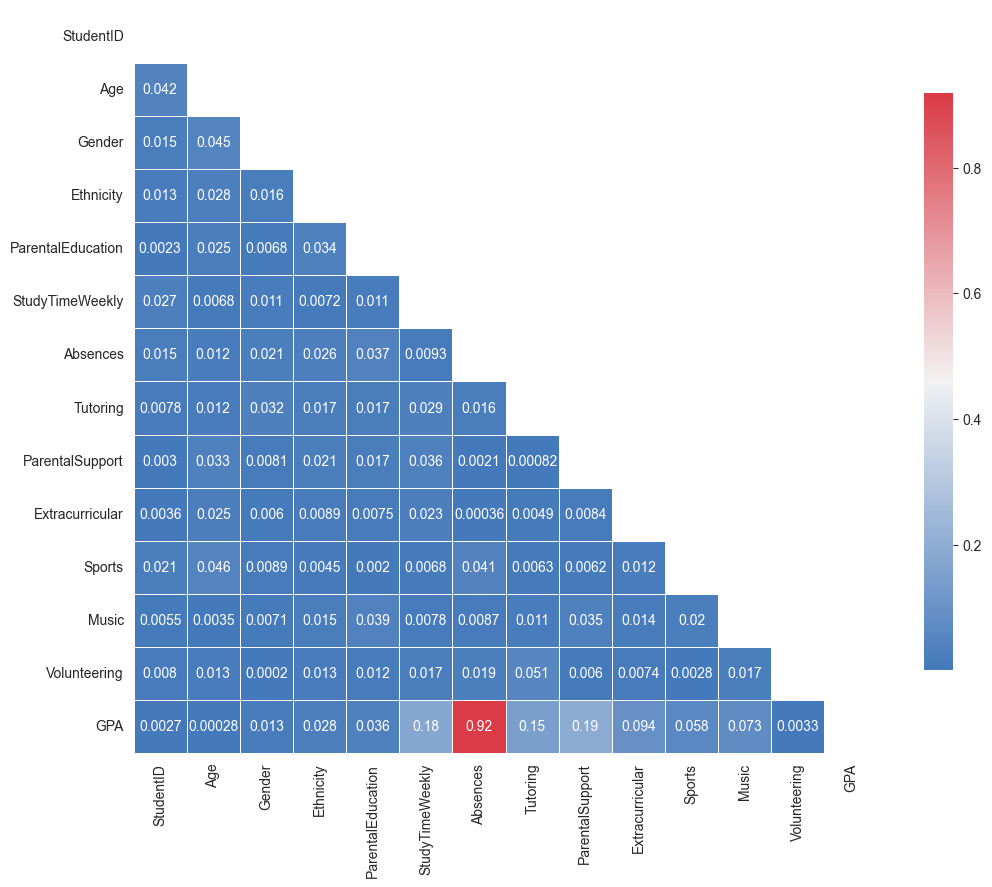

In [14]:
CorrPlot(df_inputs, figsize = (12, 10))

Removing Irrelevant Data

In [15]:
df_cleaned = df.drop(columns = ['Age', 'Volunteering', 'Gender', 'Ethnicity', 'Sports', 'Music', 'ParentalEducation',
                                'Extracurricular', 'StudentID', 'GradeClass'])

display(df_cleaned.head())

,StudyTimeWeekly,Absences,Tutoring,ParentalSupport,GPA
0,19.833723,7,1,2,2.929196
1,15.408756,0,0,1,3.042915
2,4.210570,26,0,2,0.112602
3,10.028829,14,0,3,2.054218
4,4.672495,17,1,3,1.288061


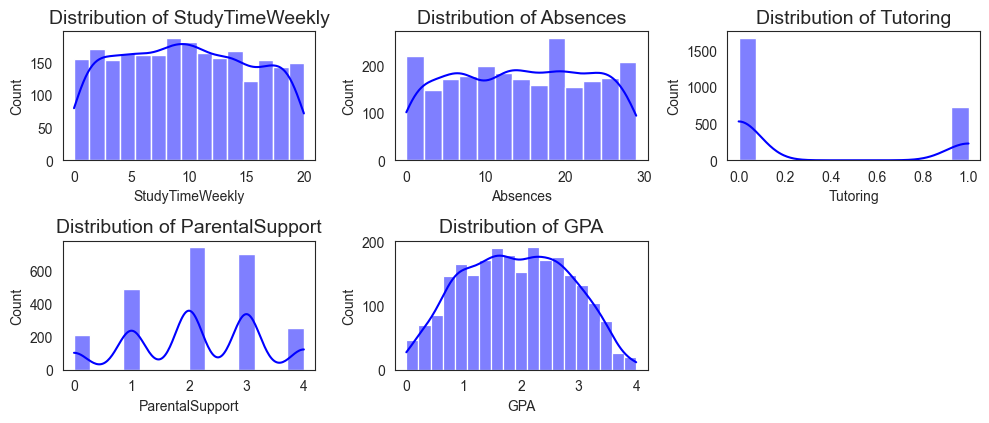

In [16]:
plt.figure(figsize=(10, 6))
for i, col in enumerate(df_cleaned.columns):
    plt.subplot(3, 3, i + 1)
    sns.histplot(df_cleaned[col], kde=True, color='blue', alpha=0.5)
    plt.title(f'Distribution of {col}', fontsize=14)
    plt.tight_layout()
plt.show()

## Univariate Analysis ##

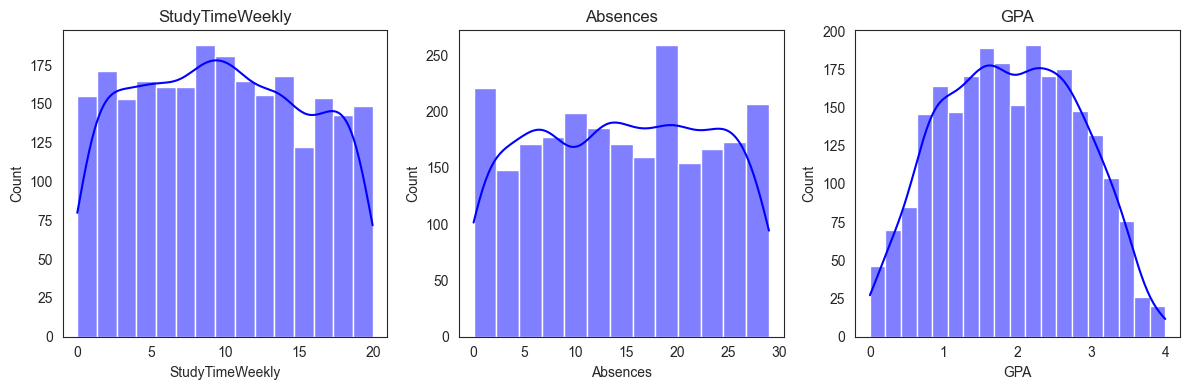

In [17]:
selected_features = ['StudyTimeWeekly', 'Absences', 'GPA']  

plt.figure(figsize=(12, 4))
for i, col in enumerate(selected_features):
    plt.subplot(1, 3, i+1)
    sns.histplot(df[col], kde=True, color='blue', alpha=0.5)
    plt.title(col)
plt.tight_layout()
plt.show()

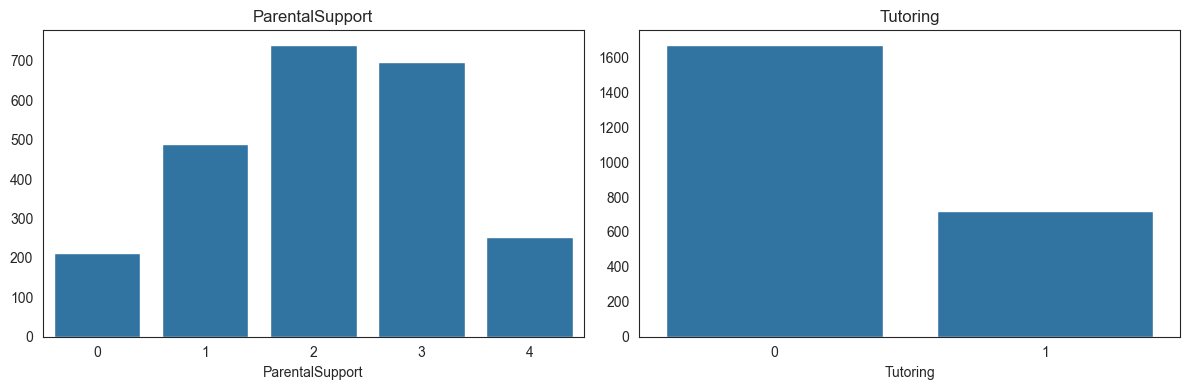

In [18]:
chosen_features = ['ParentalSupport', 'Tutoring']  

plt.figure(figsize=(12, 4))
for i, col in enumerate(chosen_features):
    plt.subplot(1, 2, i+1)
    sns.barplot(x=df[col].value_counts().index, y=df[col].value_counts().values)
    plt.title(col)
plt.tight_layout()
plt.show()

## Bivariate Analysis ##

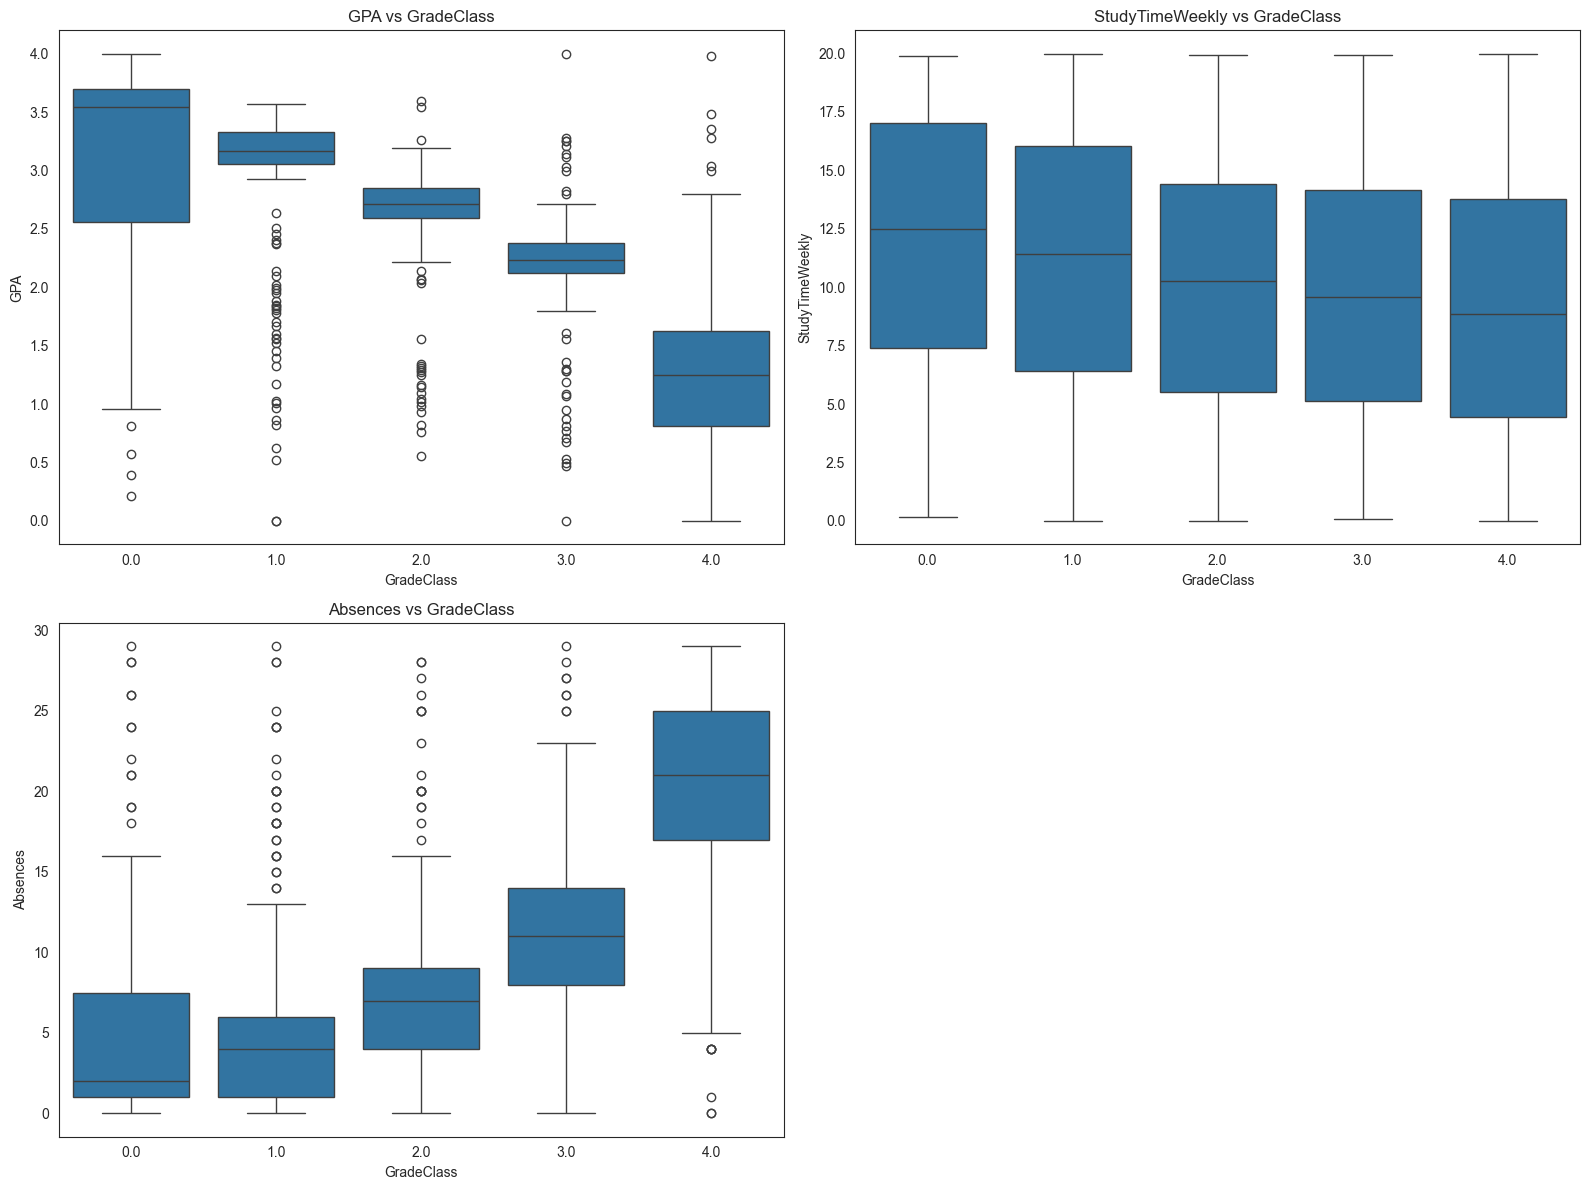

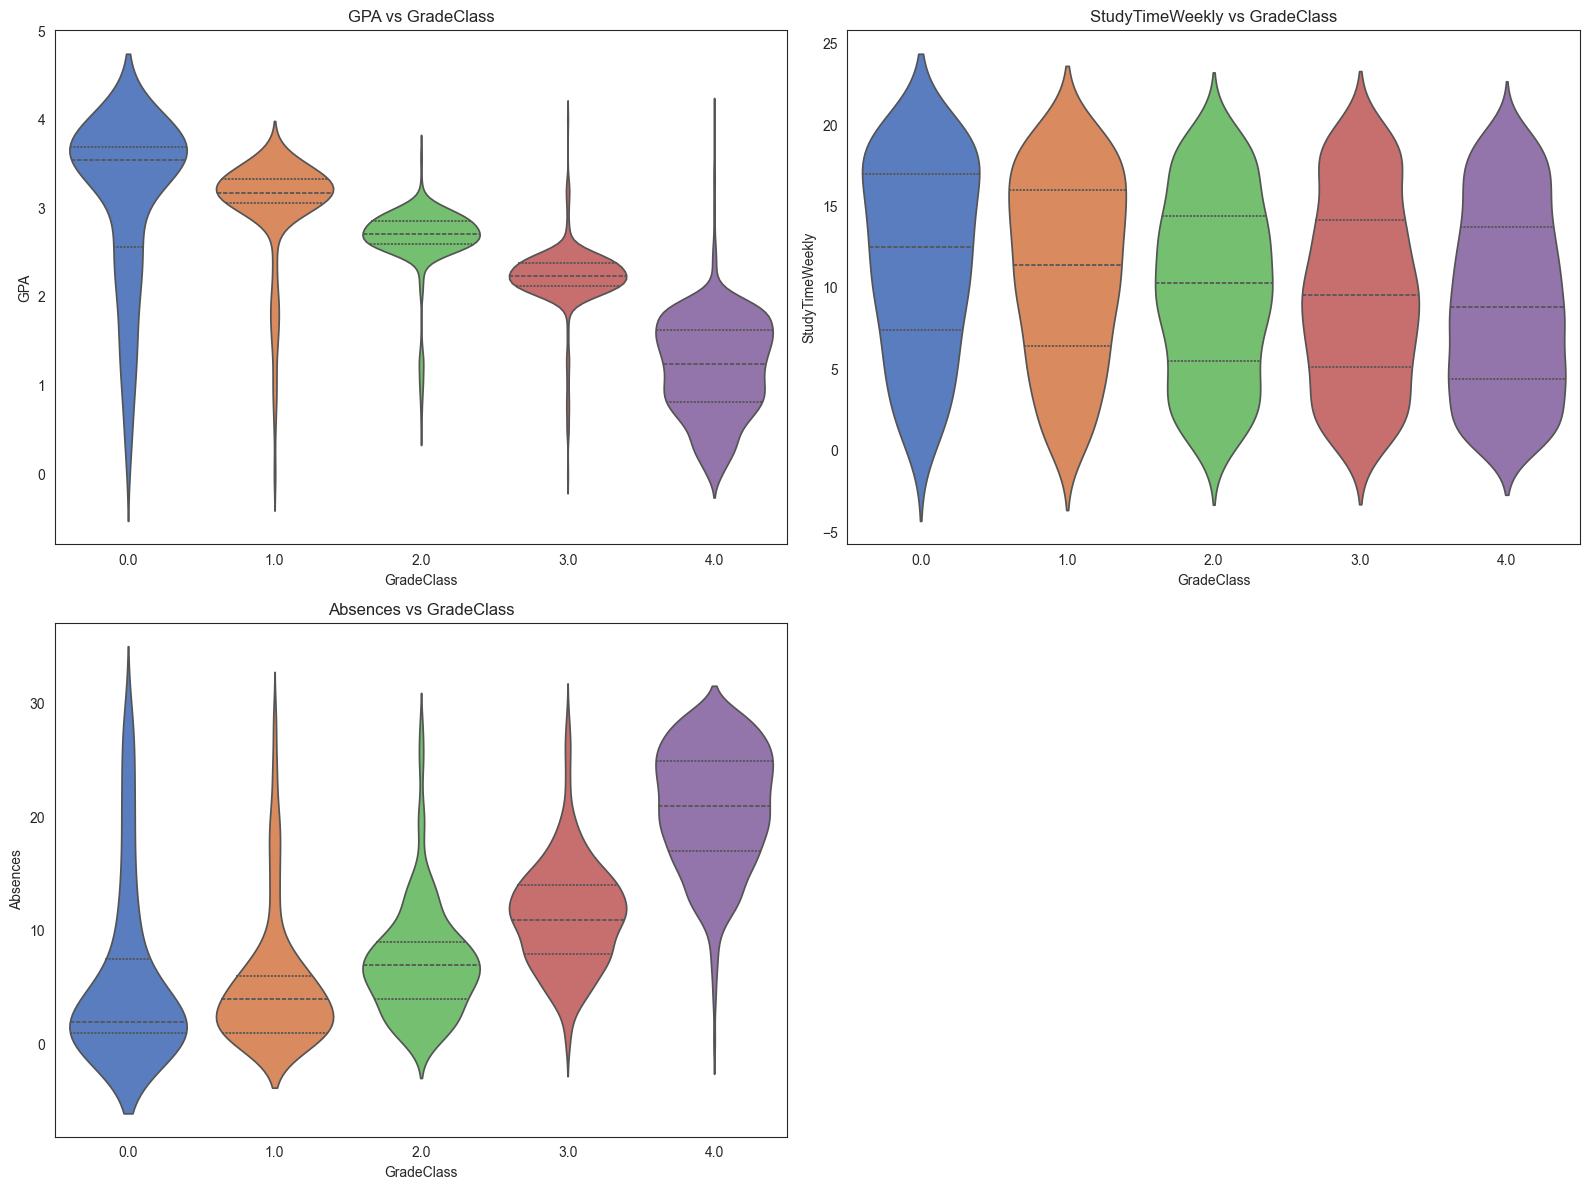

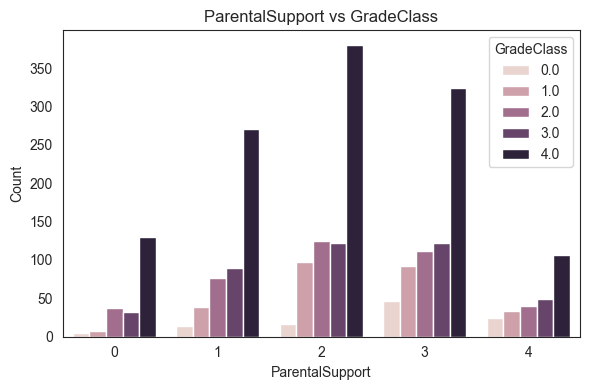

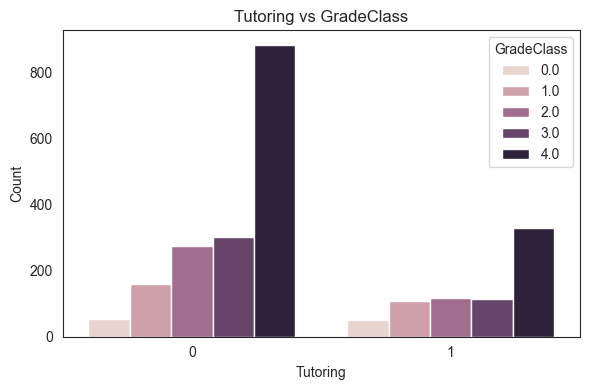

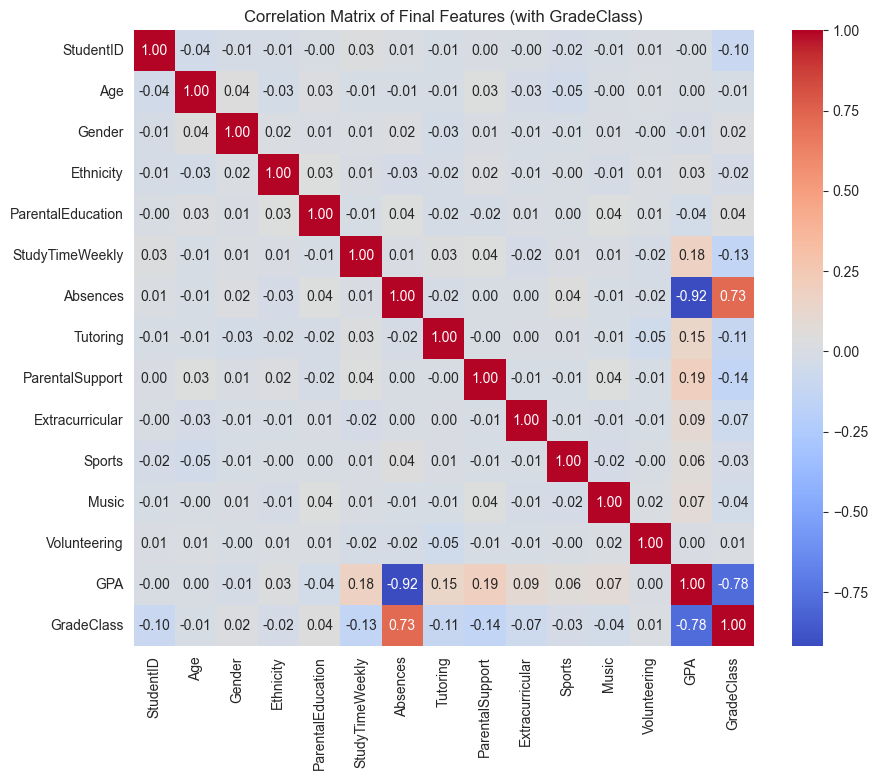

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Updated numerical features (only ones that exist in df)
numerical_features = ['GPA', 'StudyTimeWeekly', 'Absences']

# boxplot
plt.figure(figsize=(16, 12))
for i, col in enumerate(numerical_features):
    plt.subplot(2, 2, i + 1)
    sns.boxplot(x='GradeClass', y=col, data=df)
    plt.title(f'{col} vs GradeClass')
plt.tight_layout()
plt.show()

# violin plots
plt.figure(figsize=(16, 12))
for i, col in enumerate(numerical_features):
    plt.subplot(2, 2, i + 1)
    sns.violinplot(x='GradeClass', y=col, data=df, inner='quartile', hue='GradeClass', palette='muted', legend=False)
    plt.title(f'{col} vs GradeClass')
plt.tight_layout()
plt.show()

# categorical features
categorical_features = ['ParentalSupport', 'Tutoring']

for feature in categorical_features:
    plt.figure(figsize=(6, 4))
    sns.countplot(x=feature, hue='GradeClass', data=df)
    plt.title(f'{feature} vs GradeClass')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.legend(title='GradeClass')
    plt.tight_layout()
    plt.show()

# heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix of Final Features (with GradeClass)')
plt.show()


## Missing Values and Outlier Treatment ##

1. Check again for missing values

In [20]:
df_cleaned.isnull().sum()

StudyTimeWeekly    0
Absences           0
Tutoring           0
ParentalSupport    0
GPA                0
dtype: int64

2. Boxplot for cleaned features

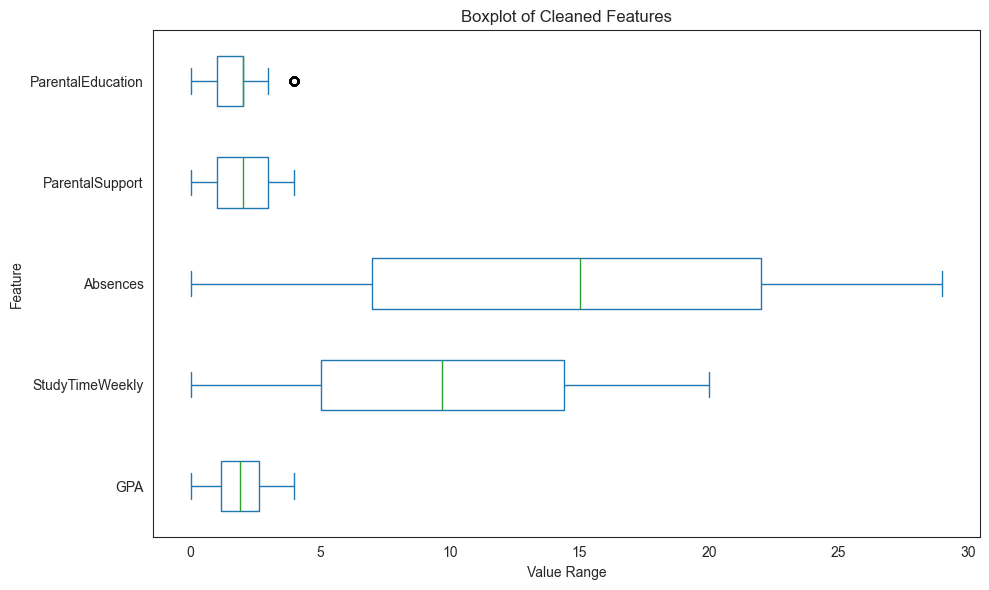

In [21]:
#boxplot with cleaned features
numerical_features = ['GPA', 'StudyTimeWeekly', 'Absences', 'ParentalSupport', 'ParentalEducation']
df[numerical_features].plot.box(vert=False, figsize=(10, 6), title='Boxplot of Cleaned Features')
plt.xlabel("Value Range")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


Checking Skewness

In [22]:
for col in df_cleaned.columns:
    print(f'{col} = {df_cleaned[col].skew()}')

StudyTimeWeekly = 0.05006807255835409
Absences = -0.026017090405395748
Tutoring = 0.8660445294904519
ParentalSupport = -0.16685872350058553
GPA = 0.014525601346976225


Scaling the data

In [23]:
scaler = StandardScaler()
df_scaled = pd.DataFrame(
    scaler.fit_transform(df_cleaned),
    index=df_cleaned.index,
    columns=df_cleaned.columns
)

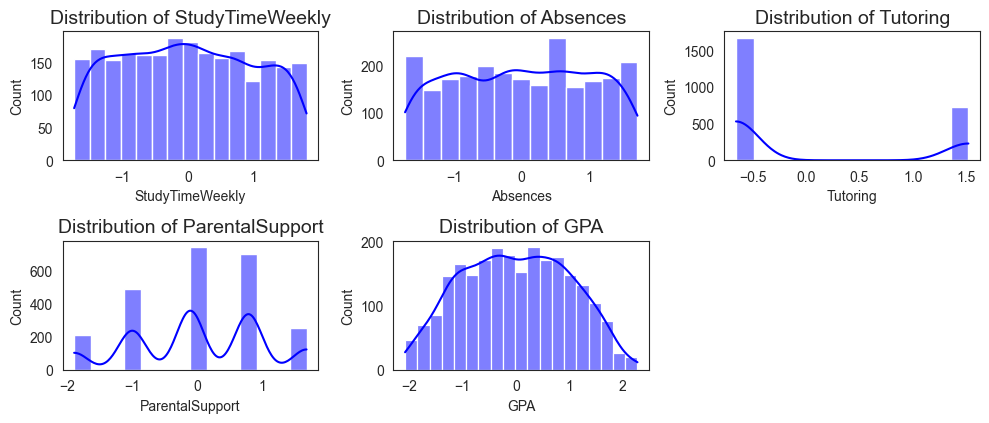

In [24]:
plt.figure(figsize=(10, 6))
for i, col in enumerate(df_scaled.columns):
    plt.subplot(3, 3, i + 1)
    sns.histplot(df_scaled[col], kde=True, color='blue', alpha=0.5)
    plt.title(f'Distribution of {col}', fontsize=14)
    plt.tight_layout()
plt.show()

Remove outliers 


In [25]:
iso = IsolationForest(contamination=0.1, random_state=42)
outliers = iso.fit_predict(df_scaled)

# 3. Select only the inliers (outliers == 1) — index is preserved here
df_removed_outliers = df_scaled.loc[outliers == 1].copy()

# 4. Reattach your target
df_removed_outliers['GradeClass'] = df_outputs.loc[df_removed_outliers.index]

# Quick check
display(df_removed_outliers.head())
print(df_removed_outliers.shape)

,StudyTimeWeekly,Absences,Tutoring,ParentalSupport,GPA,GradeClass
0,1.780336,-0.890822,1.522371,-0.108744,1.118086,2.0
1,0.997376,-1.717694,-0.656870,-0.999551,1.242374,1.0
2,-0.984045,1.353542,-0.656870,-0.108744,-1.960277,4.0
3,0.045445,-0.063951,-0.656870,0.782063,0.161790,3.0
4,-0.902311,0.290422,1.522371,0.782063,-0.675573,4.0


(2152, 6)


## Evaluation Metrics for Classification Problem ##

In [26]:
X = df_removed_outliers.drop(columns=[output_var])
y = df_removed_outliers[output_var]

display(X, y)

,StudyTimeWeekly,Absences,Tutoring,ParentalSupport,GPA
0,1.780336,-0.890822,1.522371,-0.108744,1.118086
1,0.997376,-1.717694,-0.656870,-0.999551,1.242374
2,-0.984045,1.353542,-0.656870,-0.108744,-1.960277
3,0.045445,-0.063951,-0.656870,0.782063,0.161790
4,-0.902311,0.290422,1.522371,0.782063,-0.675573
...,...,...,...,...,...
2385,-1.473312,0.644796,-0.656870,0.782063,-0.558006
2386,0.715202,-0.063951,-0.656870,-0.108744,0.102624
2389,-0.524895,0.644796,-0.656870,-0.108744,-0.834845
2390,0.467950,0.290422,-0.656870,-0.108744,-0.112452


0       2.0
1       1.0
2       4.0
3       3.0
4       4.0
       ... 
2385    1.0
2386    4.0
2389    2.0
2390    1.0
2391    1.0
Name: GradeClass, Length: 2152, dtype: float64

Splitting to Training and test data

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Training the Model

In [28]:
model = RandomForestClassifier(random_state=90)
model.fit(X_train, y_train)

#Predict
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

Calculating metrics

In [29]:
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f'Train Accuracy: {np.round(100*train_accuracy, 1)}%')

test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'Test Accuracy: {np.round(100*test_accuracy, 1)}%')

Train Accuracy: 100.0%
Test Accuracy: 89.6%


Classification report

In [30]:
report_dict = classification_report(y_test, y_test_pred, output_dict=True, zero_division=0)
report_df = pd.DataFrame(report_dict).transpose()

styled_report = report_df.style.background_gradient(cmap='YlGnBu').format("{:.2f}")
display(styled_report)

,precision,recall,f1-score,support
0.0,0.89,0.47,0.62,17.00
1.0,0.91,0.76,0.83,54.00
2.0,0.94,0.88,0.91,75.00
3.0,0.88,0.88,0.88,82.00
4.0,0.88,0.98,0.93,203.00
accuracy,0.90,0.90,0.90,0.90
macro avg,0.90,0.79,0.83,431.00
weighted avg,0.90,0.90,0.89,431.00


Confusion matrix

[[ 44   0   0   0   0]
 [  0 185   0   0   0]
 [  0   0 291   0   0]
 [  0   0   0 322   0]
 [  0   0   0   0 879]]
Training Prediction Accuracy: 100.0%


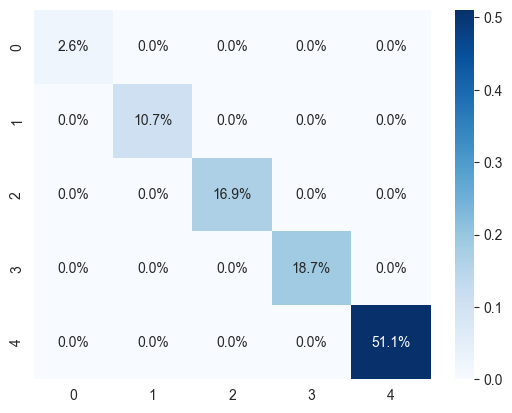

In [31]:
cm_train = confusion_matrix(y_train, y_train_pred)
print(cm_train)
cm_train_prob = cm_train/np.sum(cm_train)
_ = sns.heatmap(cm_train_prob, annot=True,cmap='Blues', fmt='.1%')
print(f'Training Prediction Accuracy: {np.round(100 * train_accuracy, 1)}%')

[[  8   2   0   2   5]
 [  0  41   2   2   9]
 [  1   0  66   3   5]
 [  0   2   1  72   7]
 [  0   0   1   3 199]]
Test Prediction Accuracy: 100.0%


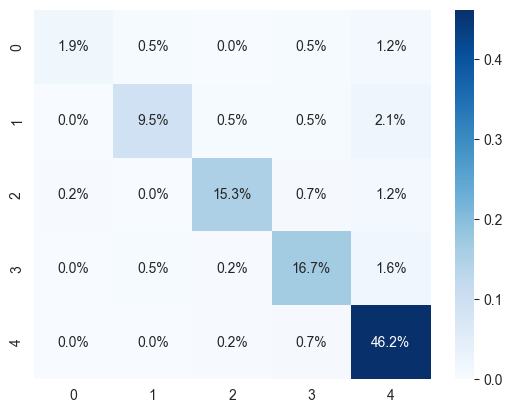

In [32]:
cm_test = confusion_matrix(y_test, y_test_pred)
print(cm_test)
cm_test_prob = cm_test/np.sum(cm_test)
_ = sns.heatmap(cm_test_prob, annot=True,cmap='Blues', fmt='.1%')

#print(f'For the following test values: {X_test.flatten()}')
print(f'Test Prediction Accuracy: {np.round(100 * train_accuracy, 1)}%')

## Feature Engineering ##

In [33]:
#Creating the new features
#Using the cleaned data, because then I will scale them with the new features
df_new_features = df_cleaned.copy()

#How can parental support and tutoring increase the performance of students?
df_new_features['SupportScore'] = df_new_features['ParentalSupport'] + df_new_features['Tutoring']

#Does parental support incre the GPA of students?
df_new_features['SupportedGPA'] = df_new_features['GPA'] * df_new_features['ParentalSupport']

#Does tutoring and study time affect the performance of students?
df_new_features['ExtraWork'] = df_new_features['StudyTimeWeekly'] * df_new_features['Tutoring']

In [34]:
display(df_new_features.head())

,StudyTimeWeekly,Absences,Tutoring,ParentalSupport,GPA,SupportScore,SupportedGPA,ExtraWork
0,19.833723,7,1,2,2.929196,3,5.858391,19.833723
1,15.408756,0,0,1,3.042915,1,3.042915,0.000000
2,4.210570,26,0,2,0.112602,2,0.225205,0.000000
3,10.028829,14,0,3,2.054218,3,6.162654,0.000000
4,4.672495,17,1,3,1.288061,4,3.864184,4.672495


Boxplot

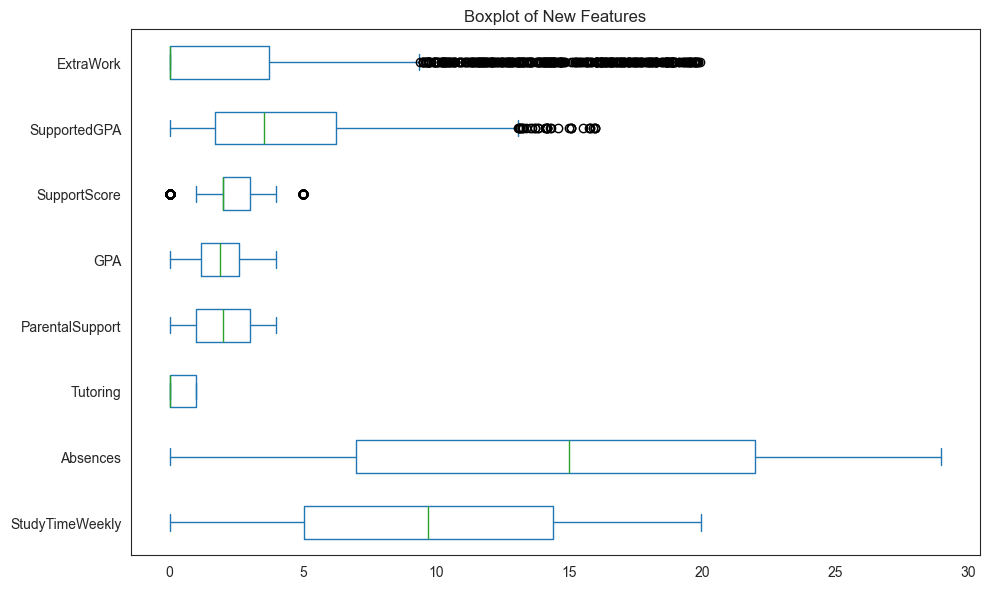

In [35]:

df_new_features.plot.box(vert=False, figsize=(10, 6), title='Boxplot of New Features')
plt.tight_layout()
plt.show()

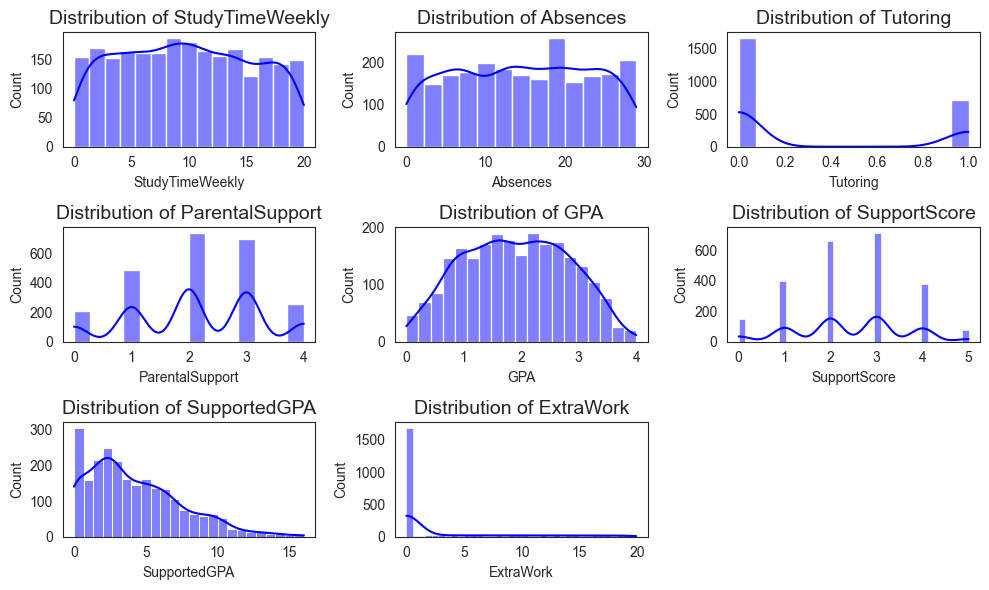

In [36]:
plt.figure(figsize=(10, 6))
for i, col in enumerate(df_new_features.columns):
    plt.subplot(3, 3, i + 1)
    sns.histplot(df_new_features[col], kde=True, color='blue', alpha=0.5)
    plt.title(f'Distribution of {col}', fontsize=14)
    plt.tight_layout()
plt.show()

Check Skewness

In [37]:
for col in df_new_features.columns:
    print(f'{col} = {df_new_features[col].skew()}')

StudyTimeWeekly = 0.05006807255835409
Absences = -0.026017090405395748
Tutoring = 0.8660445294904519
ParentalSupport = -0.16685872350058553
GPA = 0.014525601346976225
SupportScore = -0.09288602235642462
SupportedGPA = 0.8397580146364794
ExtraWork = 1.6825424874285464


Transforming the new features

In [38]:
df_feat = df_new_features.copy()

In [39]:
features_to_transform = ['ExtraWork', 'SupportedGPA']

In [40]:
pt = PowerTransformer(method='yeo-johnson')  

df_feat[features_to_transform] = pt.fit_transform(df_feat[features_to_transform])

In [41]:
for col in features_to_transform:
    #print(col, round(df_feat[col].skew(), 2))
    print(f'{col} = {df_feat[col].skew()}')

ExtraWork = 0.9328868253534139
SupportedGPA = -0.05737947998188417


Transformed data

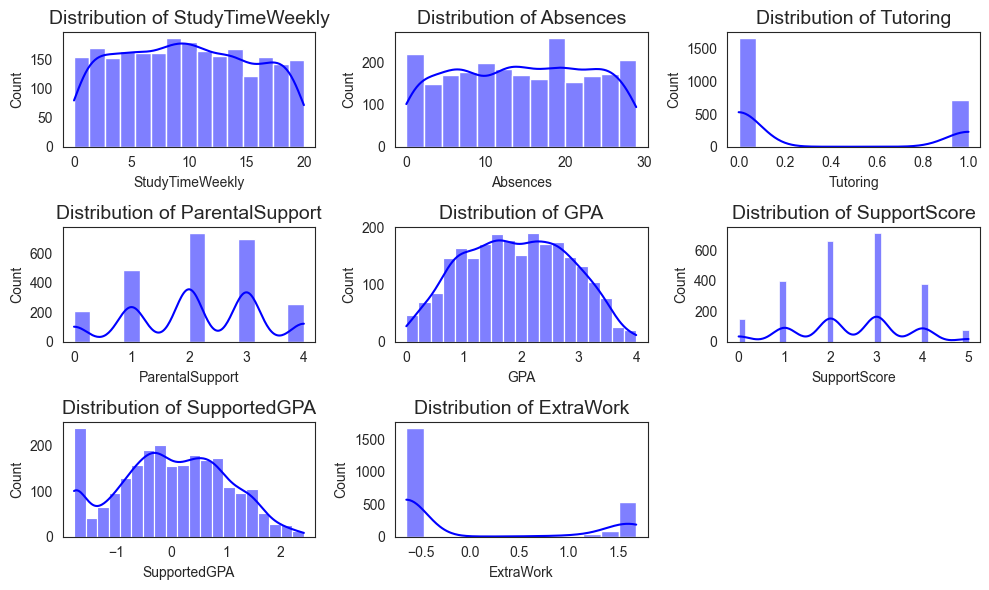

In [42]:
plt.figure(figsize=(10, 6))
for i, col in enumerate(df_feat.columns):
    plt.subplot(3, 3, i + 1)
    sns.histplot(df_feat[col], kde=True, color='blue', alpha=0.5)
    plt.title(f'Distribution of {col}', fontsize=14)
    plt.tight_layout()
plt.show()

Scale data

In [43]:
scaler = StandardScaler()
df_new_scaled = pd.DataFrame(
    scaler.fit_transform(df_feat),
    index=df_feat.index,
    columns=df_feat.columns
)

Histoplot of scaled data

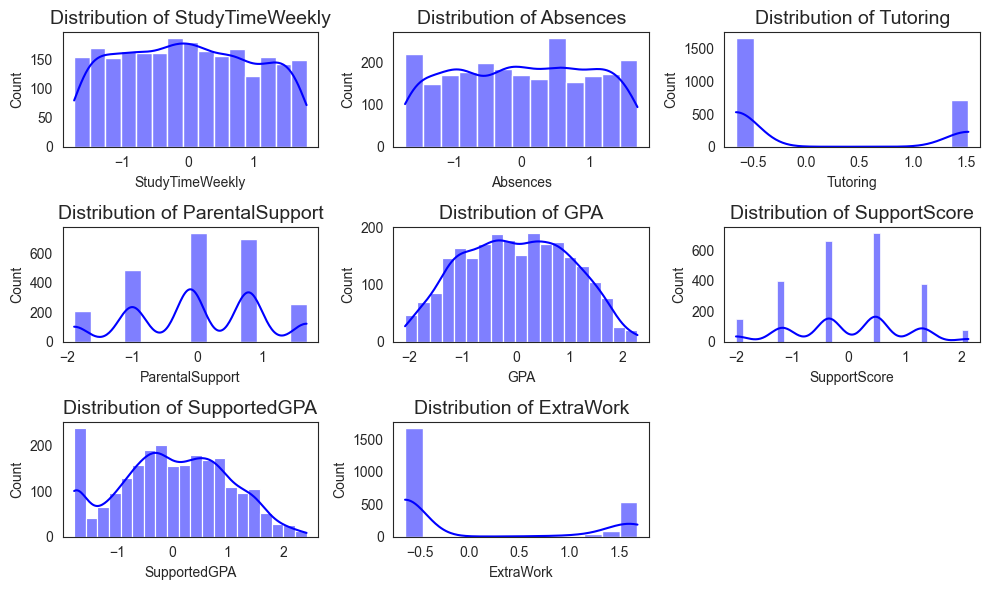

In [44]:
plt.figure(figsize=(10, 6))
for i, col in enumerate(df_new_scaled.columns):
    plt.subplot(3, 3, i + 1)
    sns.histplot(df_new_scaled[col], kde=True, color='blue', alpha=0.5)
    plt.title(f'Distribution of {col}', fontsize=14)
    plt.tight_layout()
plt.show()

Remove outliers

In [45]:
iso = IsolationForest(contamination=0.1, random_state=42)
outliers_new = iso.fit_predict(df_new_scaled)

# 3. Select only the inliers (outliers == 1) — index is preserved here
df_removed_new = df_new_scaled.loc[outliers_new == 1].copy()

# 4. Reattach your target
df_removed_new['GradeClass'] = df_outputs.loc[df_removed_new.index]

# Quick check
display(df_removed_new.head())
print(df_removed_new.shape)

,StudyTimeWeekly,Absences,Tutoring,ParentalSupport,GPA,SupportScore,SupportedGPA,ExtraWork,GradeClass
0,1.780336,-0.890822,1.522371,-0.108744,1.118086,0.475510,0.652855,1.688259,2.0
1,0.997376,-1.717694,-0.656870,-0.999551,1.242374,-1.174119,-0.164608,-0.646326,1.0
2,-0.984045,1.353542,-0.656870,-0.108744,-1.960277,-0.349305,-1.576979,-0.646326,4.0
3,0.045445,-0.063951,-0.656870,0.782063,0.161790,0.475510,0.726278,-0.646326,3.0
4,-0.902311,0.290422,1.522371,0.782063,-0.675573,1.300324,0.106005,1.458818,4.0


(2152, 9)


## Baseline Algorithms ##

In [46]:
X = df_removed_new.drop(columns=['GradeClass'])
y = df_removed_new['GradeClass']

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [48]:
model = RandomForestClassifier(random_state=90)
model.fit(X_train, y_train)

#Predict
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

In [49]:
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
print("Test accuracy:", rf.score(X_test, y_test))

Test accuracy: 0.9280742459396751


In [50]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print("Test accuracy:", model.score(X_test, y_test))

Test accuracy: 0.8700696055684455


In [51]:
xgb = XGBClassifier(eval_metric='mlogloss')
xgb.fit(X_train, y_train)
y_train_pred = xgb.predict(X_train)
y_test_pred = xgb.predict(X_test)

print("Test accuracy:", xgb.score(X_test, y_test))

Test accuracy: 0.925754060324826


## Deep Learning - MLPClassifier ##

In [52]:
# Dropping the StudentID due to redundancy as well as changing the grade class to an int from float. 
##df = df.drop(columns=['StudentID'])
##df['GradeClass'] = df['GradeClass'].astype(int)
df.shape ## to confirm result 

(2392, 15)

In [53]:
# Split features and target
X = df.drop(columns=['GradeClass'])
y = df['GradeClass']

print(X.shape)
print(y.shape)


(2392, 14)
(2392,)


In [54]:
from sklearn.model_selection import train_test_split

# splitting the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)


(1913, 14) (479, 14)
(1913,) (479,)


In [55]:
from sklearn.preprocessing import StandardScaler
## using standardscaler to scale the features for neural networks 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print(X_train_scaled.shape)
print(X_test_scaled.shape)

(1913, 14)
(479, 14)


In [56]:
from sklearn.neural_network import MLPClassifier

## a basic training model
mlp = MLPClassifier(
    hidden_layer_sizes=(64, 32),  # 2 hidden layers with 64 and 32 neurons respectively
    activation='relu',
    solver='adam',
    max_iter=500,
    random_state=42
)

mlp.fit(X_train_scaled, y_train)


MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)

## Model Evaluation

Accuracy: 0.8246

Classification Report:
              precision    recall  f1-score   support

         0.0       0.77      0.45      0.57        22
         1.0       0.63      0.69      0.66        49
         2.0       0.74      0.71      0.72        85
         3.0       0.76      0.76      0.76        86
         4.0       0.92      0.95      0.94       237

    accuracy                           0.82       479
   macro avg       0.76      0.71      0.73       479
weighted avg       0.82      0.82      0.82       479



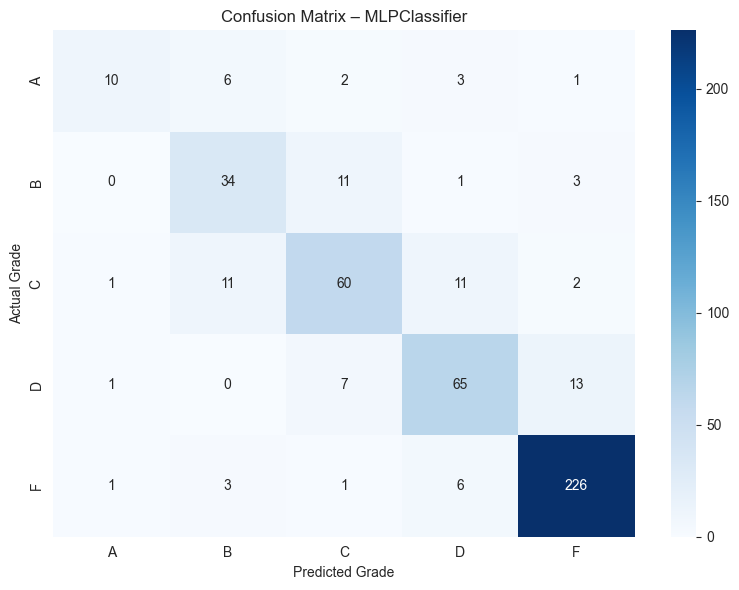

In [57]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Make predictions on the test set
y_pred = mlp.predict(X_test_scaled)

# 2. Accuracy Score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# 3. Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# 4. Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d',
            xticklabels=['A', 'B', 'C', 'D', 'F'],
            yticklabels=['A', 'B', 'C', 'D', 'F'])
plt.xlabel('Predicted Grade')
plt.ylabel('Actual Grade')
plt.title('Confusion Matrix – MLPClassifier')
plt.tight_layout()
plt.show()


### Summary of Results
- Model: MLPClassifier
- Accuracy: 82.46%
- Best Performance: Grade F (f1 = 0.94)
- Most Confused: Grade A ↔ B (low support)
- Deployment: Dash app hosted at [your render link]


In [58]:
import joblib

# using joblib to save the model for dash deployment
joblib.dump(mlp, 'mlp_model.pkl')

# saving the scalar just incase its needed
joblib.dump(scaler, 'scaler.pkl')

print("Model and scaler saved successfully.")


Model and scaler saved successfully.


# Retraining a new mini scalar for technicalities 

In [61]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import pickle

# cleaned dataframe
df = pd.read_csv('Student_performance_data .csv')

# 5 features i want to scale
features = ['GPA', 'StudyTimeWeekly', 'Absences', 'ParentalSupport', 'ParentalEducation']

# dropping rows with missing values in these columns
df_filtered = df[features].dropna()

#new scaler
new_scaler = StandardScaler()
new_scaler.fit(df_filtered)

# saves to scaler.pkl and replaces old file if there is one
with open('scaler.pkl', 'wb') as f:
    pickle.dump(new_scaler, f)

print(" New scaler trained and saved for Dash app.")


 New scaler trained and saved for Dash app.
